In [21]:
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import time

iterations = [1, 5, 10, 15, 20]

In [22]:
def process_dataset(filename):
    file = open(filename, 'r')
    data = []
    arr = []
    for line in file:
        numbers = re.findall(r'-?\d+(?:\.\d+)?', line)
        numbers = [int(num) if '.' not in num else float(num) for num in numbers]
        data.append(numbers)
    data = np.array(data)

    users_size = int(data[0][0])
    item_size = int(data[0][1])
    m = np.zeros((users_size, item_size))
    data = data[1:]
    train_data = data[:data.shape[0]//2]
    test_data = data[data.shape[0]//2:]
    
    for i in range(train_data.shape[0]):
        m[int(train_data[i][0])][int(train_data[i][1])] = train_data[i][2]

    return users_size, item_size, m, train_data, test_data

In [23]:
def variational_bayes(m, users_size, item_size, rank, train_data, iterations):
    Phi = [np.identity(rank)] * users_size
    Psi = [np.identity(rank)] * item_size

    rho_sq = [1/rank] * rank
    sigma_sq = [1] * rank
    Tau_sq = 1
    
    mean_u = np.random.normal(loc=0, scale=1, size=(users_size, rank))
    mean_v = np.random.normal(loc=0, scale=1, size=(item_size, rank)) 
    
    while iterations > 0:
        mean_uv_error = []
        
        #E-step
        for i in range(users_size):
            mean_u_old = np.copy(mean_u[i])
            S_i = np.identity(rank)
            for l in range(rank):
                S_i[l][l] = S_i[l][l] * (1/sigma_sq[l])
            sum1 = 0
            sum2 = 0
            for u, j, s in train_data:
                if i == int(u):
                    j = int(j)
                    sum1 += (Psi[j] + np.outer(mean_v[j], mean_v[j].T))/Tau_sq
                    sum2 += (m[i][j] * mean_v[j])/Tau_sq
            sum1 += np.zeros((rank,rank))
            sum2 += np.zeros(rank)
            Phi[i] = np.linalg.inv(S_i + sum1)
            mean_u[i] = np.dot(Phi[i], sum2)
            error = np.linalg.norm(mean_u[i] - mean_u_old)
            mean_uv_error.append(error)
            
        for j in range(item_size):
            mean_v_old = np.copy(mean_v[j])
            S_j = np.identity(rank)
            for l in range(rank):
                S_j[l][l] = S_j[l][l] * (1/rho_sq[l])
            sum1 = 0
            sum2 = 0
            for i, it, s in train_data:
                if j == int(it):
                    i = int(i)
                    sum1 += (Phi[i] + np.outer(mean_u[i], mean_u[i].T))/Tau_sq
                    sum2 += (m[i][j] * mean_u[i])/Tau_sq
            sum2 += np.zeros(rank)
            sum1 += np.zeros((rank,rank))
            Psi[j] = np.linalg.inv(S_j + sum1)
            mean_v[j] = np.dot(Psi[j], sum2)
            error = np.linalg.norm(mean_v[j] - mean_v_old)
            mean_uv_error.append(error)
            
            #M-Step
        for l in range(rank):
            temp = 0
            for i in range(users_size):
                temp += Phi[i][l][l] + (mean_u[i][l] ** 2)
            sigma_sq[l] = (1/(users_size - 1)) * temp
            
        sum = 0
        K = train_data.shape[0]
        for i, j, s in train_data:
            i = int(i)
            j = int(j)
            temp1 = Phi[i] + np.outer(mean_u[i],mean_u[i].T)
            temp2 = Psi[j] + np.outer(mean_v[j],mean_v[j].T)
            temp3 = temp1 * temp2
            sum += (m[i][j] ** 2) - (2 * m[i][j] * np.dot(mean_u[i],mean_v[j].T)) + np.sum(temp3)
        Tau_sq = (1/(K-1)) * sum
        
        
        if np.max(abs(np.array(mean_uv_error))) < 0.01:
            break
        iterations -= 1
    
    
        
    return mean_u, mean_v

In [24]:
def baseline_model(filename):
    users_size, item_size, m, train_data, test_data = process_dataset(filename)
    N = train_data.shape[0]
    sum = 0
    for i, j, score in train_data:
        sum += score
    c = sum/N
    
    a = [0] * users_size
    for i in range (users_size):
        sum = 0
        N=0
        for user, item, score in train_data:
            if i == int(user):
                N += 1
                sum += score
        if N != 0:
            a[i] = sum / N
        else:
            a[i] = c
    b = [0] * item_size
    for j in range (item_size):
        sum = 0
        N=0
        for user, item, score in train_data:
            if j == int(item):
                N += 1
                sum += score
        if N != 0:
            b[j] = sum / N
        else:
            b[j] = c

    N = test_data.shape[0]
    sum_error = 0
    for i, j, score in test_data:
        i = int(i)
        j = int(j)
        pred_value = (a[i] + b[j])/2
        sum_error += ((pred_value) - score) ** 2
    rmse = math.sqrt(sum_error/N)
    return rmse

In [25]:
def vi_matrix_factorization_model(filename, rank, iterations):
    users_size, item_size, m, train_data, test_data = process_dataset(filename)
    start = time.time()
    mean_u, mean_v = variational_bayes(m, users_size, item_size, rank, train_data, iterations)
    time_taken = (time.time() - start) 
    N = train_data.shape[0]
    sum_error = 0
    for i, j, score in train_data:
        i = int(i)
        j = int(j)
        pred_value = np.dot(mean_u[i], mean_v[j].T)
        sum_error += ((pred_value) - score) ** 2
    rmse_train = math.sqrt(sum_error/N)
    
    N = test_data.shape[0]
    sum_error = 0
    for i, j, score in test_data:
        i = int(i)
        j = int(j)
        pred_value = np.dot(mean_u[i], mean_v[j].T)
        sum_error += ((pred_value) - score) ** 2
    rmse_test = math.sqrt(sum_error/N)
    return rmse_train, rmse_test, time_taken

In [26]:
filename = "hw2data/data-40-20-2.txt"
rank = 2
it = 100
rmse_train_matrixAlg, rmse_test_matrixAlg, time_taken = vi_matrix_factorization_model(filename, rank, it)
rmse_baseline = baseline_model(filename)
print("RMSE for Baseline model on data-40-20-2 dataset: " + str(rmse_baseline))
print("RMSE for Matrix factorization algorithm on data-40-20-2 dataset: " + str(rmse_test_matrixAlg))
print("Time Taken: " + str(time_taken))

RMSE for Baseline model on data-40-20-2 dataset: 1.6038626145141004
RMSE for Matrix factorization algorithm on data-40-20-2 dataset: 1.559465500256642
Time Taken: 0.2923400402069092


In [27]:
def experiment_ml_100k_iterations(iterations):
    filename = "hw2data/ml-100k.txt"
    d = 5
    rmse_train_list = []
    rmse_test_list = []
    time_list = []
    for i in range(len(iterations)):
        rmse_train, rmse_test, time_taken = vi_matrix_factorization_model(filename, d, iterations[i])
        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
        time_list.append(time_taken)
    rmse_baseline = baseline_model(filename)
    return rmse_train_list, rmse_test_list, rmse_baseline, time_list

In [28]:
rmse_train_iterationList, rmse_test_iterationList, rmse_baseline, time_iterationList =  experiment_ml_100k_iterations(iterations)
print(f'RMSE for Baseline model on ml-100k dataset:\n{rmse_baseline}\n')
print(f'Trainset RMSE for Matrix factorization algorithm on ml-100k dataset:\n{rmse_train_iterationList}\n')
print(f'Testset RMSE for Matrix factorization algorithm on ml-100k dataset:\n{rmse_test_iterationList}\n')
print(f'Time taken for each iterations on ml-100k dataset:\n{time_iterationList}\n')

RMSE for Baseline model on ml-100k dataset:
0.987077661785431

Trainset RMSE for Matrix factorization algorithm on ml-100k dataset:
[3.1346149379000994, 0.8856999821064543, 0.8475142178717391, 0.8371820833241175, 0.8114342626193253]

Testset RMSE for Matrix factorization algorithm on ml-100k dataset:
[3.3523981254162605, 0.9764807805268304, 0.960245923231339, 0.9596497376779604, 0.9572013363790863]

Time taken for each iterations on ml-100k dataset:
[97.9582929611206, 491.2160429954529, 982.4216120243073, 1471.5200171470642, 1947.568200826645]



<function matplotlib.pyplot.show(close=None, block=None)>

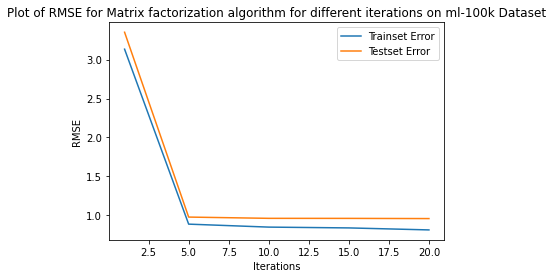

In [29]:
plt.plot(iterations, rmse_train_iterationList, label = 'Trainset Error')
plt.plot(iterations, rmse_test_iterationList, label = 'Testset Error')
plt.title('Plot of RMSE for Matrix factorization algorithm for different iterations on ml-100k Dataset') 
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

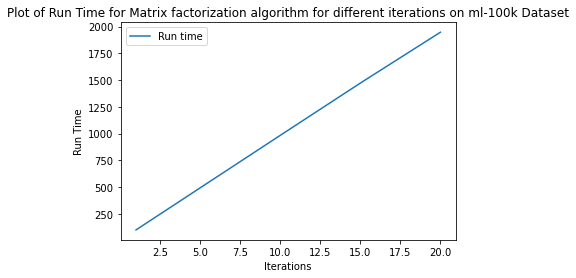

In [30]:
plt.plot(iterations, time_iterationList, label = 'Run time')
plt.title('Plot of Run Time for Matrix factorization algorithm for different iterations on ml-100k Dataset') 
plt.ylabel('Run Time')
plt.xlabel('Iterations')
plt.legend(loc='best')
plt.show